In [1]:
import astropy.units as u
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia
from gala.coordinates import *
import matplotlib.pyplot as plt
import pandas as pd

from episode_functions import *

In [2]:
filename = 'gd1_data.hdf'
centerline_df = pd.read_hdf(filename, 'centerline_df')
selected_df = pd.read_hdf(filename, 'selected_df')

In [3]:
pm1_min = -8.9
pm1_max = -6.9
pm2_min = -2.2
pm2_max =  1.0

pm1_rect, pm2_rect = make_rectangle(
    pm1_min, pm1_max, pm2_min, pm2_max)
gd1_frame = GD1Koposov10()

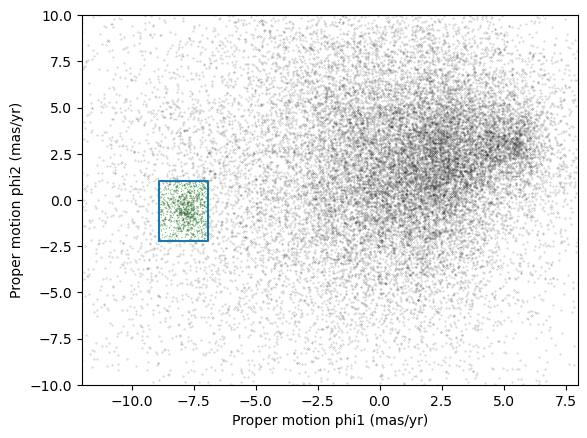

In [4]:
plot_proper_motion(centerline_df)
plt.plot(pm1_rect,pm2_rect)

x = selected_df['pm_phi1']
y = selected_df['pm_phi2']
plt.plot(x, y, 'gx', markersize=0.3, alpha=0.3)
plt.savefig("prop_mot_only.png")

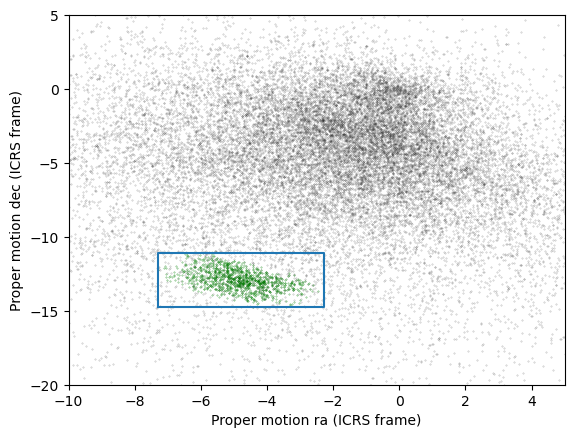

In [5]:
x=centerline_df["pmra"]
y=centerline_df["pmdec"]
plt.plot(x,y,"ko",alpha=0.3,markersize=0.3)
x=selected_df["pmra"]
y=selected_df["pmdec"]
plt.plot(x, y, 'gx', markersize=1, alpha=0.3)
plt.xlabel('Proper motion ra (ICRS frame)')
plt.ylabel('Proper motion dec (ICRS frame)')
plt.xlim([-10, 5])
plt.ylim([-20, 5])

pm1_ICRS_max=max(selected_df["pmra"])
pm1_ICRS_min=min(selected_df["pmra"])
pm2_ICRS_max=max(selected_df["pmdec"])
pm2_ICRS_min=min(selected_df["pmdec"])

pm1_ICRS_rect,pm2_ICRS_rect=make_rectangle(pm1_ICRS_min,pm1_ICRS_max,pm2_ICRS_min,pm2_ICRS_max)
plt.plot(pm1_ICRS_rect,pm2_ICRS_rect)
plt.savefig("prop_mot_only_ICRS.png")

In [6]:
phi1_min = -70 * u.degree
phi1_max = -20 * u.degree
phi2_min = -5 * u.degree
phi2_max = 5 * u.degree
phi1_rect, phi2_rect = make_rectangle(
    phi1_min, phi1_max, phi2_min, phi2_max)

In [7]:
corners=SkyCoord(phi1=phi1_rect,phi2=phi2_rect,frame=gd1_frame)
corners_icrs=corners.transform_to("icrs")
sky_point_list=skycoord_to_string(corners_icrs)
sky_point_list

'135.306, 8.39862, 126.51, 13.4449, 163.017, 54.2424, 172.933, 46.4726, 135.306, 8.39862'

In [8]:
columns= "source_id,ra,dec,pmra,pmdec"

candidate_coord_query_base = """SELECT
{columns}
FROM gaiadr2.gaia_source
WHERE parallax < 1
  AND bp_rp BETWEEN -0.75 AND 2 
  AND 1 = CONTAINS(POINT(ra, dec), 
                   POLYGON({sky_point_list}))"""
candidate_coor_query=candidate_coord_query_base.format(columns=columns,sky_point_list=sky_point_list)

In [9]:
candidate_coord_pm_query_base= """SELECT
{columns}
FROM gaiadr2.gaia_source
WHERE parallax < 1
    AND pmra BETWEEN {pm1_ICRS_min} AND {pm1_ICRS_max}
    AND pmdec BETWEEN {pm2_ICRS_min} AND {pm2_ICRS_max}
  AND bp_rp BETWEEN -0.75 AND 2 
  AND 1 = CONTAINS(POINT(ra, dec), 
                   POLYGON({sky_point_list}))"""
candidate_coord_pm_query=candidate_coord_pm_query_base.format(columns=columns,sky_point_list=sky_point_list,pm1_ICRS_min=pm1_ICRS_min,
                                                              pm1_ICRS_max=pm1_ICRS_max,pm2_ICRS_min=pm2_ICRS_min,pm2_ICRS_max=pm2_ICRS_max)

In [10]:
candidate_coord_pm_job = Gaia.launch_job_async(candidate_coord_pm_query)
print(candidate_coord_pm_job)

INFO: Query finished. [astroquery.utils.tap.core]
<Table length=13052>
   name    dtype    unit                              description                            
--------- ------- -------- ------------------------------------------------------------------
SOURCE_ID   int64          Unique source identifier (unique within a particular Data Release)
       ra float64      deg                                                    Right ascension
      dec float64      deg                                                        Declination
     pmra float64 mas / yr                         Proper motion in right ascension direction
    pmdec float64 mas / yr                             Proper motion in declination direction
Jobid: 1716838203937O
Phase: COMPLETED
Owner: None
Output file: async_20240527193003.vot
Results: None


In [11]:
candidate_gaia_table = candidate_coord_pm_job.get_results()
len(candidate_gaia_table)

13052

In [12]:
d = dict(sky_point_list=sky_point_list, pmra_min=pm1_ICRS_min, pmra_max=pm1_ICRS_max, pmdec_min=pm2_ICRS_min, pmdec_max=pm2_ICRS_max)
d

{'sky_point_list': '135.306, 8.39862, 126.51, 13.4449, 163.017, 54.2424, 172.933, 46.4726, 135.306, 8.39862',
 'pmra_min': -7.306415190921692,
 'pmra_max': -2.268479190206636,
 'pmdec_min': -14.75623260987968,
 'pmdec_max': -11.05981294804957}

In [13]:
point_series=pd.Series(d)
point_series

sky_point_list    135.306, 8.39862, 126.51, 13.4449, 163.017, 54...
pmra_min                                                  -7.306415
pmra_max                                                  -2.268479
pmdec_min                                                -14.756233
pmdec_max                                                -11.059813
dtype: object

In [14]:
filename="gd1_data.hdf"
point_series.to_hdf(filename,"point_series")

/tmp/ipykernel_7217/1131143028.py:2: FutureWarning: Starting with pandas version 3.0 all arguments of to_hdf except for the argument 'path_or_buf' will be keyword-only.
  point_series.to_hdf(filename,"point_series")
/tmp/ipykernel_7217/1131143028.py:2: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->values] [items->None]

  point_series.to_hdf(filename,"point_series")


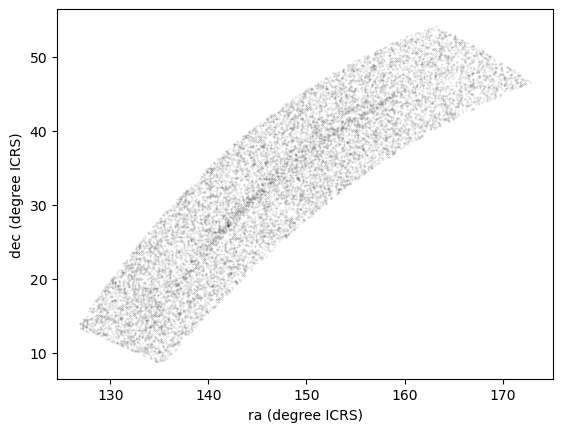

In [15]:
x = candidate_gaia_table['ra']
y = candidate_gaia_table['dec']
plt.plot(x, y, 'ko', markersize=0.3, alpha=0.2)

plt.xlabel('ra (degree ICRS)')
plt.ylabel('dec (degree ICRS)')

plt.savefig("prop_mot.png")

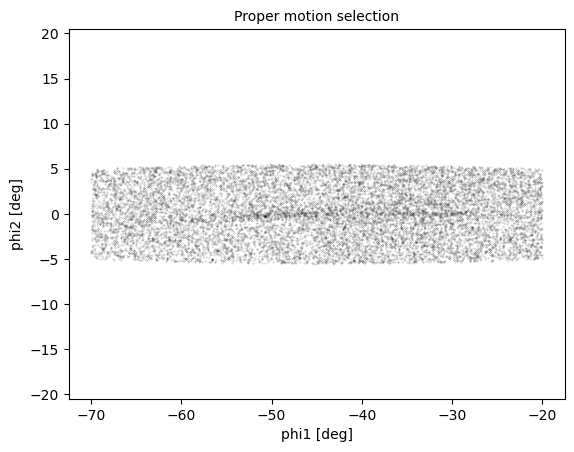

In [16]:
candidate_gaia_df=make_dataframe(candidate_gaia_table)
plot_pm_selection(candidate_gaia_df)
plt.savefig("prop_mot_GD1.png")

In [17]:
pmra_min = point_series['pmra_min']
pmra_max = point_series['pmra_max']
pmdec_min = point_series['pmdec_min']
pmdec_max = point_series['pmdec_max']

In [18]:
ps_best_neighbour_meta= Gaia.load_table("gaiadr2.panstarrs1_best_neighbour")

In [19]:
print(ps_best_neighbour_meta)

TAP Table name: gaiadr2.gaiadr2.panstarrs1_best_neighbour
Description: Pan-STARRS1 BestNeighbour table lists each matched Gaia object with its
best neighbour in the external catalogue.
There are 1 327 157 objects in the filtered version of Pan-STARRS1 used
to compute this cross-match that have too early epochMean.
Num. columns: 7


In [20]:
for column in ps_best_neighbour_meta.columns:
    print(column.name)

source_id
original_ext_source_id
angular_distance
number_of_neighbours
number_of_mates
best_neighbour_multiplicity
gaia_astrometric_params


In [21]:
ps_best_neighbour_query = """SELECT 
TOP 5
source_id, best_neighbour_multiplicity, number_of_mates, original_ext_source_id
FROM gaiadr2.panstarrs1_best_neighbour
"""
ps_best_neighbour_job = Gaia.launch_job_async(ps_best_neighbour_query)

INFO: Query finished. [astroquery.utils.tap.core]


In [22]:
ps_best_neighbour_results = ps_best_neighbour_job.get_results()
ps_best_neighbour_results

SOURCE_ID,best_neighbour_multiplicity,number_of_mates,original_ext_source_id
int64,int16,int16,int64
6745938972433480704,1,0,69742925668851205
6030466788955954048,1,0,69742509325691172
6756488099308169600,1,0,69742879438541228
6700154994715046016,1,0,69743055581721207
6757061941303252736,1,0,69742856540241198


In [23]:
ps_valid_meta= Gaia.load_table("gaiadr2.panstarrs1_original_valid")

In [24]:
print(ps_valid_meta)

TAP Table name: gaiadr2.gaiadr2.panstarrs1_original_valid
Description: The Panoramic Survey Telescope and Rapid Response System (Pan-STARRS) is
a system for wide-field astronomical imaging developed and operated by
the Institute for Astronomy at the University of Hawaii. Pan-STARRS1
(PS1) is the first part of Pan-STARRS to be completed and is the basis
for Data Release 1 (DR1). The PS1 survey used a 1.8 meter telescope and
its 1.4 Gigapixel camera to image the sky in five broadband filters (g,
r, i, z, y).

The current table contains a filtered subsample of the 10 723 304 629
entries listed in the original ObjectThin table.
We used only ObjectThin and MeanObject tables to extract
panstarrs1OriginalValid table, this means that objects detected only in
stack images are not included here. The main reason for us to avoid the
use of objects detected in stack images is that their astrometry is not
as good as the mean objects astrometry: “The stack positions (raStack,
decStack) have considera

In [25]:
for columns in ps_valid_meta.columns:
    print(columns.name)

obj_name
obj_id
ra
dec
ra_error
dec_error
epoch_mean
g_mean_psf_mag
g_mean_psf_mag_error
g_flags
r_mean_psf_mag
r_mean_psf_mag_error
r_flags
i_mean_psf_mag
i_mean_psf_mag_error
i_flags
z_mean_psf_mag
z_mean_psf_mag_error
z_flags
y_mean_psf_mag
y_mean_psf_mag_error
y_flags
n_detections
zone_id
obj_info_flag
quality_flag


In [26]:
ps_valid_query = """SELECT 
TOP 5
obj_id, g_mean_psf_mag, i_mean_psf_mag 
FROM gaiadr2.panstarrs1_original_valid
"""
ps_valid_job = Gaia.launch_job_async(ps_valid_query)

INFO: Query finished. [astroquery.utils.tap.core]


In [27]:
ps_valid_results = ps_valid_job.get_results()
ps_valid_results

obj_id,g_mean_psf_mag,i_mean_psf_mag
,,mag
int64,float64,float64
67130655389101425,--,20.3516006469727
67553305590067819,--,19.779899597168
67551423248967849,--,19.8889007568359
67132026238911331,--,20.9062995910645
67553513677687787,--,21.2831001281738


In [28]:
test_cone_query = """SELECT 
TOP 10 
source_id
FROM gaiadr2.gaia_source
WHERE 1=CONTAINS(
  POINT(ra, dec),
  CIRCLE(88.8, 7.4, 0.08333333))
"""
test_cone_job=Gaia.launch_job(test_cone_query)


In [29]:
test_cone_results=test_cone_job.get_results()
test_cone_results

SOURCE_ID
int64
3322773965056065536
3322773758899157120
3322774068134271104
3322773930696320512
3322774377374425728
3322773724537891456
3322773724537891328
3322773930696321792
3322773724537890944


In [30]:
cone_base_query="""SELECT 
{columns}
FROM gaiadr2.gaia_source
WHERE 1=CONTAINS(
  POINT(ra, dec),
  CIRCLE(88.8, 7.4, 0.08333333))
"""
columns = 'source_id, ra, dec, pmra, pmdec'

cone_query = cone_base_query.format(columns=columns)
print(cone_query)

SELECT 
source_id, ra, dec, pmra, pmdec
FROM gaiadr2.gaia_source
WHERE 1=CONTAINS(
  POINT(ra, dec),
  CIRCLE(88.8, 7.4, 0.08333333))



In [31]:
cone_job=Gaia.launch_job(cone_query)


In [32]:
cone_job_results=cone_job.get_results()
cone_job_results

SOURCE_ID,ra,dec,pmra,pmdec
,deg,deg,mas / yr,mas / yr
int64,float64,float64,float64,float64
3322773965056065536,88.78178020183375,7.334936530583141,0.2980633722108194,-2.5057036964736907
3322773758899157120,88.83227057144585,7.325577341429926,--,--
3322774068134271104,88.8206092188033,7.353158142762173,-1.1065462654445488,-1.5260889445858044
3322773930696320512,88.80843339290348,7.334853162299928,2.6074384482375215,-0.9292104395445717
3322774377374425728,88.86806108182265,7.371287731275939,3.9555477866915383,-3.8676624830902435
3322773724537891456,88.81308602813434,7.32488574492059,51.34995462741039,-33.078133430952086
3322773724537891328,88.81570329208743,7.3223019772324855,1.9389988498951845,0.3110526931576576
3322773930696321792,88.8050736770331,7.332371472206583,2.264014834476311,1.0772755505138008


In [33]:
neighbours_base_query = """SELECT 
{columns}
FROM gaiadr2.gaia_source AS gaia
JOIN gaiadr2.panstarrs1_best_neighbour AS best
  USING(source_id)
WHERE 1=CONTAINS(
  POINT(gaia.ra, gaia.dec),
  CIRCLE(88.8, 7.4, 0.08333333))
"""
column_list_neighbours = ['gaia.source_id',
               'gaia.ra',
               'gaia.dec',
               'gaia.pmra',
               'gaia.pmdec',
               'best.best_neighbour_multiplicity',
               'best.number_of_mates',
              ]
columns = ', '.join(column_list_neighbours)
neighbours_query = neighbours_base_query.format(columns=columns)
print(neighbours_query)

SELECT 
gaia.source_id, gaia.ra, gaia.dec, gaia.pmra, gaia.pmdec, best.best_neighbour_multiplicity, best.number_of_mates
FROM gaiadr2.gaia_source AS gaia
JOIN gaiadr2.panstarrs1_best_neighbour AS best
  USING(source_id)
WHERE 1=CONTAINS(
  POINT(gaia.ra, gaia.dec),
  CIRCLE(88.8, 7.4, 0.08333333))



In [34]:
neighbours_job = Gaia.launch_job_async(neighbours_query)


INFO: Query finished. [astroquery.utils.tap.core]


In [35]:
neighbours_results = neighbours_job.get_results()
neighbours_results

SOURCE_ID,ra,dec,pmra,pmdec,best_neighbour_multiplicity,number_of_mates
,deg,deg,mas / yr,mas / yr,,
int64,float64,float64,float64,float64,int16,int16
3322773965056065536,88.78178020183375,7.334936530583141,0.2980633722108194,-2.5057036964736907,1,0
3322774068134271104,88.8206092188033,7.353158142762173,-1.1065462654445488,-1.5260889445858044,1,0
3322773930696320512,88.80843339290348,7.334853162299928,2.6074384482375215,-0.9292104395445717,1,0
3322774377374425728,88.86806108182265,7.371287731275939,3.9555477866915383,-3.8676624830902435,1,0
3322773724537891456,88.81308602813434,7.32488574492059,51.34995462741039,-33.078133430952086,1,0
3322773724537891328,88.81570329208743,7.3223019772324855,1.9389988498951845,0.3110526931576576,1,0
3322773930696321792,88.8050736770331,7.332371472206583,2.264014834476311,1.0772755505138008,1,0
3322773724537890944,88.81241651540533,7.327864052479726,-0.36003627434304625,-6.393939291541333,1,0


In [36]:
hel_base_query= """SELECT 
{columns}
FROM gaiadr2.gaia_source AS gaia
JOIN gaiadr2.panstarrs1_best_neighbour AS best
  USING(source_id)
JOIN gaiadr2.panstarrs1_original_valid AS ps
 ON best.original_ext_source_id = ps.obj_id
WHERE 1=CONTAINS(
  POINT(gaia.ra, gaia.dec),
  CIRCLE(88.8, 7.4, 0.08333333))
"""
column_list_hel = ['gaia.source_id',
               'gaia.ra',
               'gaia.dec',
               'gaia.pmra',
               'gaia.pmdec',
               'best.best_neighbour_multiplicity',
               'best.number_of_mates',
               'ps.g_mean_psf_mag',
                'ps.i_mean_psf_mag'
              ]
columns = ', '.join(column_list_hel)
hel_query = hel_base_query.format(columns=columns)
print(hel_query)

SELECT 
gaia.source_id, gaia.ra, gaia.dec, gaia.pmra, gaia.pmdec, best.best_neighbour_multiplicity, best.number_of_mates, ps.g_mean_psf_mag, ps.i_mean_psf_mag
FROM gaiadr2.gaia_source AS gaia
JOIN gaiadr2.panstarrs1_best_neighbour AS best
  USING(source_id)
JOIN gaiadr2.panstarrs1_original_valid AS ps
 ON best.original_ext_source_id = ps.obj_id
WHERE 1=CONTAINS(
  POINT(gaia.ra, gaia.dec),
  CIRCLE(88.8, 7.4, 0.08333333))



In [37]:
hel_job=Gaia.launch_job_async(hel_query)


INFO: Query finished. [astroquery.utils.tap.core]


In [38]:
hel_results = hel_job.get_results()
hel_results

SOURCE_ID,ra,dec,pmra,pmdec,best_neighbour_multiplicity,number_of_mates,g_mean_psf_mag,i_mean_psf_mag
,deg,deg,mas / yr,mas / yr,,,,mag
int64,float64,float64,float64,float64,int16,int16,float64,float64
3322773965056065536,88.78178020183375,7.334936530583141,0.2980633722108194,-2.5057036964736907,1,0,19.9431991577148,17.4221992492676
3322774068134271104,88.8206092188033,7.353158142762173,-1.1065462654445488,-1.5260889445858044,1,0,18.6212005615234,16.6007995605469
3322773930696320512,88.80843339290348,7.334853162299928,2.6074384482375215,-0.9292104395445717,1,0,--,20.2203998565674
3322774377374425728,88.86806108182265,7.371287731275939,3.9555477866915383,-3.8676624830902435,1,0,18.0676002502441,16.9762001037598
3322773724537891456,88.81308602813434,7.32488574492059,51.34995462741039,-33.078133430952086,1,0,20.1907005310059,17.8700008392334
3322773724537891328,88.81570329208743,7.3223019772324855,1.9389988498951845,0.3110526931576576,1,0,22.6308002471924,19.6004009246826
3322773930696321792,88.8050736770331,7.332371472206583,2.264014834476311,1.0772755505138008,1,0,21.2119998931885,18.3528003692627
3322773724537890944,88.81241651540533,7.327864052479726,-0.36003627434304625,-6.393939291541333,1,0,20.8094005584717,18.1343002319336


In [39]:
candidate_coord_pm_query_base = """SELECT 
{columns}
FROM gaiadr2.gaia_source
WHERE parallax < 1
  AND bp_rp BETWEEN -0.75 AND 2 
  AND 1 = CONTAINS(POINT(ra, dec), 
                   POLYGON({sky_point_list}))
  AND pmra BETWEEN {pmra_min} AND  {pmra_max}
  AND pmdec BETWEEN {pmdec_min} AND {pmdec_max}
"""
columns = 'source_id, ra, dec, pmra, pmdec'

candidate_coord_pm_query = candidate_coord_pm_query_base.format(columns=columns,
                            sky_point_list=sky_point_list,
                            pmra_min=pmra_min,
                            pmra_max=pmra_max,
                            pmdec_min=pmdec_min,
                            pmdec_max=pmdec_max)

print(candidate_coord_pm_query)

SELECT 
source_id, ra, dec, pmra, pmdec
FROM gaiadr2.gaia_source
WHERE parallax < 1
  AND bp_rp BETWEEN -0.75 AND 2 
  AND 1 = CONTAINS(POINT(ra, dec), 
                   POLYGON(135.306, 8.39862, 126.51, 13.4449, 163.017, 54.2424, 172.933, 46.4726, 135.306, 8.39862))
  AND pmra BETWEEN -7.306415190921692 AND  -2.268479190206636
  AND pmdec BETWEEN -14.75623260987968 AND -11.05981294804957



In [40]:
candidate_coord_pm_job = Gaia.launch_job_async(candidate_coord_pm_query)

INFO: Query finished. [astroquery.utils.tap.core]


In [41]:
candidate_coord_pm_results=candidate_coord_pm_job.get_results()
candidate_coord_pm_results

SOURCE_ID,ra,dec,pmra,pmdec
,deg,deg,mas / yr,mas / yr
int64,float64,float64,float64,float64
635559124339440000,137.58671691646745,19.1965441084838,-3.770521900009566,-12.490481778113859
635860218726658176,138.5187065217173,19.09233926905897,-5.941679495793577,-11.346409129876392
635674126383965568,138.8428741026386,19.031798198627634,-3.8970011609340207,-12.702779525389634
635535454774983040,137.8377518255436,18.864006786112604,-4.335040664412791,-14.492308604905652
635875994141946752,138.23605905977644,19.205239946957814,-2.593400800706278,-14.479241878775694
635497276810313600,138.0445160213759,19.00947118796605,-7.1729306406216615,-12.291499169815987
635614168640132864,139.59219748145836,18.807955539071433,-3.309602916796381,-13.708904908478631
635685125795548160,139.3661475544695,19.028463915477083,-2.504022538279528,-11.27170795467831


In [42]:
candidate_join_query_base= """SELECT 
{columns}
FROM gaiadr2.gaia_source AS gaia
JOIN gaiadr2.panstarrs1_best_neighbour AS best
  USING(source_id)
JOIN gaiadr2.panstarrs1_original_valid AS ps
 ON best.original_ext_source_id = ps.obj_id
WHERE parallax < 1
  AND bp_rp BETWEEN -0.75 AND 2 
  AND 1 = CONTAINS(POINT(gaia.ra, gaia.dec), 
                   POLYGON({sky_point_list}))
  AND pmra BETWEEN {pmra_min} AND  {pmra_max}
  AND pmdec BETWEEN {pmdec_min} AND {pmdec_max}
"""
column_list_candidate_join = ['gaia.source_id',
               'gaia.ra',
               'gaia.dec',
               'gaia.pmra',
               'gaia.pmdec',
               'best.best_neighbour_multiplicity',
               'best.number_of_mates',
               'ps.g_mean_psf_mag',
                'ps.i_mean_psf_mag'
              ]
columns = ', '.join(column_list_candidate_join)
candidate_join_query=candidate_join_query_base.format(columns=columns,sky_point_list=sky_point_list,
                            pmra_min=pmra_min,
                            pmra_max=pmra_max,
                            pmdec_min=pmdec_min,
                            pmdec_max=pmdec_max)
print(candidate_join_query)

SELECT 
gaia.source_id, gaia.ra, gaia.dec, gaia.pmra, gaia.pmdec, best.best_neighbour_multiplicity, best.number_of_mates, ps.g_mean_psf_mag, ps.i_mean_psf_mag
FROM gaiadr2.gaia_source AS gaia
JOIN gaiadr2.panstarrs1_best_neighbour AS best
  USING(source_id)
JOIN gaiadr2.panstarrs1_original_valid AS ps
 ON best.original_ext_source_id = ps.obj_id
WHERE parallax < 1
  AND bp_rp BETWEEN -0.75 AND 2 
  AND 1 = CONTAINS(POINT(gaia.ra, gaia.dec), 
                   POLYGON(135.306, 8.39862, 126.51, 13.4449, 163.017, 54.2424, 172.933, 46.4726, 135.306, 8.39862))
  AND pmra BETWEEN -7.306415190921692 AND  -2.268479190206636
  AND pmdec BETWEEN -14.75623260987968 AND -11.05981294804957



In [43]:
candidate_join_job=Gaia.launch_job_async(candidate_join_query)

INFO: Query finished. [astroquery.utils.tap.core]


In [44]:
candidate_table=candidate_join_job.get_results()
candidate_table

SOURCE_ID,ra,dec,pmra,pmdec,best_neighbour_multiplicity,number_of_mates,g_mean_psf_mag,i_mean_psf_mag
,deg,deg,mas / yr,mas / yr,,,,mag
int64,float64,float64,float64,float64,int16,int16,float64,float64
635860218726658176,138.5187065217173,19.09233926905897,-5.941679495793577,-11.346409129876392,1,0,17.8978004455566,17.5174007415771
635674126383965568,138.8428741026386,19.031798198627634,-3.8970011609340207,-12.702779525389634,1,0,19.2873001098633,17.6781005859375
635535454774983040,137.8377518255436,18.864006786112604,-4.335040664412791,-14.492308604905652,1,0,16.9237995147705,16.478099822998
635497276810313600,138.0445160213759,19.00947118796605,-7.1729306406216615,-12.291499169815987,1,0,19.9242000579834,18.3339996337891
635614168640132864,139.59219748145836,18.807955539071433,-3.309602916796381,-13.708904908478631,1,0,16.1515998840332,14.6662998199463
635685125795548160,139.3661475544695,19.028463915477083,-2.504022538279528,-11.27170795467831,1,0,20.014799118042,18.3934993743896
635694467349085056,139.06182692172476,19.06744237567232,-3.0674889862265795,-11.4175270465402,1,0,18.6709003448486,17.9841995239258
635877570395672448,138.28997323741356,19.232696761851464,-2.638287363184212,-13.19483842407928,1,0,21.839599609375,19.7248001098633


In [45]:
candidate_table["best_neighbour_multiplicity"]

1
1
1
1
1
1
1
1
1
1
1


In [46]:
multiplicity_table=pd.Series(candidate_table["best_neighbour_multiplicity"])
multiplicity_table.describe()

/home/kneff/miniconda3/envs/AstronomicalData/lib/python3.12/site-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  arr.partition(


count    6680.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
dtype: float64

In [47]:
mates=pd.Series(candidate_table["number_of_mates"])
mates.describe()

/home/kneff/miniconda3/envs/AstronomicalData/lib/python3.12/site-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  arr.partition(


count    6680.000000
mean        0.000299
std         0.017302
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
dtype: float64

In [48]:
candidate_df=make_dataframe(candidate_table)
candidate_df.drop(candidate_df.loc[candidate_df["number_of_mates"]!=0].index,inplace=True)
#All values with more than 0 mates are taken out to avoid ambiguous information, that is, to avoid plotting 2 sets of data for the same star

In [49]:
mates=pd.Series(candidate_df["number_of_mates"])
mates.describe()

count    6678.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: number_of_mates, dtype: float64

In [50]:
filename="gd1_data.hdf"
candidate_df.to_hdf(filename,"candidate_df")

/tmp/ipykernel_7217/2056256918.py:2: FutureWarning: Starting with pandas version 3.0 all arguments of to_hdf except for the argument 'path_or_buf' will be keyword-only.
  candidate_df.to_hdf(filename,"candidate_df")


In [51]:
from os.path import getsize

MB = 1024 * 1024
getsize(filename) / MB

15.6492919921875

In [52]:
candidate_df.to_csv('gd1_data.csv')

In [53]:
getsize('gd1_data.csv') / MB

1.364959716796875

In [54]:
read_back_csv = pd.read_csv("gd1_data.csv")
candidate_df.head(3)

,SOURCE_ID,ra,dec,pmra,pmdec,best_neighbour_multiplicity,number_of_mates,g_mean_psf_mag,i_mean_psf_mag,phi1,phi2,pm_phi1,pm_phi2
0,635860218726658176,138.518707,19.092339,-5.941679,-11.346409,1,0,17.8978,17.517401,-59.247330,-2.016078,-7.527126,1.748779
1,635674126383965568,138.842874,19.031798,-3.897001,-12.702780,1,0,19.2873,17.678101,-59.133391,-2.306901,-7.560608,-0.741800
2,635535454774983040,137.837752,18.864007,-4.335041,-14.492309,1,0,16.9238,16.478100,-59.785300,-1.594569,-9.357536,-1.218492


In [55]:
read_back_csv.head(3)

,Unnamed: 0,SOURCE_ID,ra,dec,pmra,pmdec,best_neighbour_multiplicity,number_of_mates,g_mean_psf_mag,i_mean_psf_mag,phi1,phi2,pm_phi1,pm_phi2
0,0,635860218726658176,138.518707,19.092339,-5.941679,-11.346409,1,0,17.8978,17.517401,-59.247330,-2.016078,-7.527126,1.748779
1,1,635674126383965568,138.842874,19.031798,-3.897001,-12.702780,1,0,19.2873,17.678101,-59.133391,-2.306901,-7.560608,-0.741800
2,2,635535454774983040,137.837752,18.864007,-4.335041,-14.492309,1,0,16.9238,16.478100,-59.785300,-1.594569,-9.357536,-1.218492
